### Navier Stokes in JAX

$\begin{aligned}
	&w_t+\boldsymbol{u}\cdot\nabla w=\frac{1}{\mathrm{Re}}\Delta w,\quad in[0,T]\times \Omega, \\
	&\nabla \cdot \boldsymbol{u}=0,\quad in[0,T]\times \Omega, \\
	&w(0,x,y)=w_0(x,y),\quad in\Omega, \\
	&\Omega=[0,2\pi]^2, Re=100
\end{aligned}$

In [1]:
import jax 
import jax.numpy as jnp
import numpy as np
import flax
from flax import linen as nn
from flax.training import train_state
import optax
import scipy
import matplotlib.pyplot as plt
import pickle
import copy
import time
from tqdm import trange
from typing import Sequence
from functools import partial

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
M_x = 5
M_y = 5
L_x = 2*jnp.pi
L_y = 2*jnp.pi
d0 = 2*M_x + 2*M_y + 4*M_x*M_y + 1
layer_sizes_u = [d0] + [128] * 4 + [1]
layer_sizes_v = [d0] + [128] * 4 + [1]

w_x = 2 * jnp.pi / L_x
w_y = 2 * jnp.pi / L_y
k_x = jnp.arange(1, M_x + 1)
k_y = jnp.arange(1, M_y + 1)
k_xx, k_yy = jnp.meshgrid(k_x, k_y)
k_xx = k_xx.flatten()
k_yy = k_yy.flatten()

class Net(nn.Module):
    layer_sizes: Sequence[int]

    def setup(self):
        self.W1 = nn.Dense(features=self.layer_sizes[1], kernel_init=nn.initializers.xavier_normal(), bias_init=nn.initializers.zeros_init())
        self.W2 = nn.Dense(features=self.layer_sizes[1], kernel_init=nn.initializers.xavier_normal(), bias_init=nn.initializers.zeros_init())
        self.Wz = [nn.Dense(features=size, kernel_init=nn.initializers.xavier_normal(), bias_init=nn.initializers.zeros_init()) for size in self.layer_sizes[1:]]

    def input_encoding(self, x, y):
        return jnp.hstack(
            [
                jnp.ones(x.shape),
                jnp.cos(k_x * w_x * x),
                jnp.cos(k_y * w_y * y),
                jnp.sin(k_x * w_x * x),
                jnp.sin(k_y * w_y * y),
                jnp.cos(k_xx * w_x * x) * jnp.cos(k_yy * w_y * y),
                jnp.cos(k_xx * w_x * x) * jnp.sin(k_yy * w_y * y),
                jnp.sin(k_xx * w_x * x) * jnp.cos(k_yy * w_y * y),
                jnp.sin(k_xx * w_x * x) * jnp.sin(k_yy * w_y * y),
            ]
        )

    def __call__(self, x, y):
        output = self.input_encoding(x, y)
        U = nn.tanh(self.W1(output))
        V = nn.tanh(self.W2(output))

        H = nn.tanh(self.Wz[0](output))
        for linear in self.Wz[1:-1]:
            Z = nn.tanh(linear(H))
            H = jnp.multiply(1 - Z, U) + jnp.multiply(Z, V)
        return self.Wz[-1](H)

net_u = Net(layer_sizes_u)
net_v = Net(layer_sizes_v)

In [3]:
def mse_fn(true, pred):
    return jnp.mean(jnp.square(true - pred))

def diff(func, argnums):
    return jax.grad(lambda *ar, **kw: jnp.sum(func(*ar, **kw)), argnums=argnums)

@jax.jit
def net(state, params, x, y):
    return state.apply_fn(params, x, y)

@jax.jit
def w_net(state_u, state_v, params_u, params_v, x, y):
    '''
    w = v_x - u_y
    '''
    return diff(net, 2)(state_v, params_v, x, y) - diff(net, 3)(state_u, params_u, x, y)

@jax.jit
def train_step_u0(state_u, state_v, X_star, Y_star, u0, v0, w0):
    def loss_fn(params_u, params_v):
        u_fn = lambda x, y: net(state_u, params_u, x, y)
        u_x_fn = diff(u_fn, 0)
        u_x = u_x_fn(X_star, Y_star)
        v_fn = lambda x, y: net(state_v, params_v, x, y)
        v_y_fn = diff(v_fn, 1)
        v_y = v_y_fn(X_star, Y_star)

        loss_c = mse_fn(u_x, -v_y)

        u0_pred = net(state_u, params_u, X_star, Y_star)
        v0_pred = net(state_v, params_v, X_star, Y_star)
        w0_pred = w_net(state_u, state_v, params_u, params_v, X_star, Y_star)

        loss_u = mse_fn(u0, u0_pred)
        loss_v = mse_fn(v0, v0_pred)
        loss_w = mse_fn(w0, w0_pred)

        loss = 1e5*(loss_u + loss_v + loss_w + loss_c)
        return loss, (loss_u, loss_v, loss_w, loss_c)
    
    grads_u, (loss_u, loss_v, loss_w, loss_c) = jax.grad(loss_fn, argnums=0, has_aux=True)(state_u.params, state_v.params)
    grads_v, (loss_u, loss_v, loss_w, loss_c) = jax.grad(loss_fn, argnums=1, has_aux=True)(state_u.params, state_v.params)

    state_u = state_u.apply_gradients(grads=grads_u)
    state_v = state_v.apply_gradients(grads=grads_v)
    return state_u, state_v, loss_u, loss_v, loss_w, loss_c

@jax.jit
def train_step_rest(state_u, state_v, x, y, wk, wk_x, wk_xx, wk_y, wk_yy, uk, uk_x, vk, vk_y, N_t, nu):
    def loss_fn(params_u, params_v):
        u_fn = lambda x, y: net(state_u, params_u, x, y)
        u_x_fn = diff(u_fn, 0)
        u = u_fn(x, y)
        u_x = u_x_fn(x, y)

        v_fn = lambda x, y: net(state_v, params_v, x, y)
        v_y_fn = diff(v_fn, 1)
        v = v_fn(x, y)
        v_y = v_y_fn(x, y)

        w_fn = lambda x, y: w_net(state_u, state_v, params_u, params_v, x, y)
        w_x_fn = diff(w_fn, 0)
        w_xx_fn = diff(w_x_fn, 0)
        w_y_fn = diff(w_fn, 1)
        w_yy_fn = diff(w_y_fn, 1)
        w = w_fn(x, y)
        w_x = w_x_fn(x, y)
        w_xx = w_xx_fn(x, y)
        w_y = w_y_fn(x, y)
        w_yy = w_yy_fn(x, y)

        loss_w = mse_fn((w-wk)/(1/N_t) + (u+uk)/2*(w_x+wk_x)/2 + (v+vk)/2*(w_y+wk_y)/2, nu*((w_xx+wk_xx)/2 + (w_yy+wk_yy)/2))
        # loss_c = mse_fn((u_x+uk_x)/2, -(v_y+vk_y)/2)
        loss_c = mse_fn(u_x, -v_y)
        loss = loss_w + loss_c
        loss = jax.lax.cond(loss_w>loss_c, lambda w,c: w+1e2*c, lambda w,c: 1e2*w+c, loss_w, loss_c)
        return loss, (loss, loss_w, loss_c)
    grads_u, (loss, loss_w, loss_c) = jax.grad(loss_fn, argnums=0, has_aux=True)(state_u.params, state_v.params)
    grads_v, (loss, loss_w, loss_c) = jax.grad(loss_fn, argnums=1, has_aux=True)(state_u.params, state_v.params)

    state_u = state_u.apply_gradients(grads=grads_u)
    state_v = state_v.apply_gradients(grads=grads_v)
    return state_u, state_v, loss, loss_w, loss_c

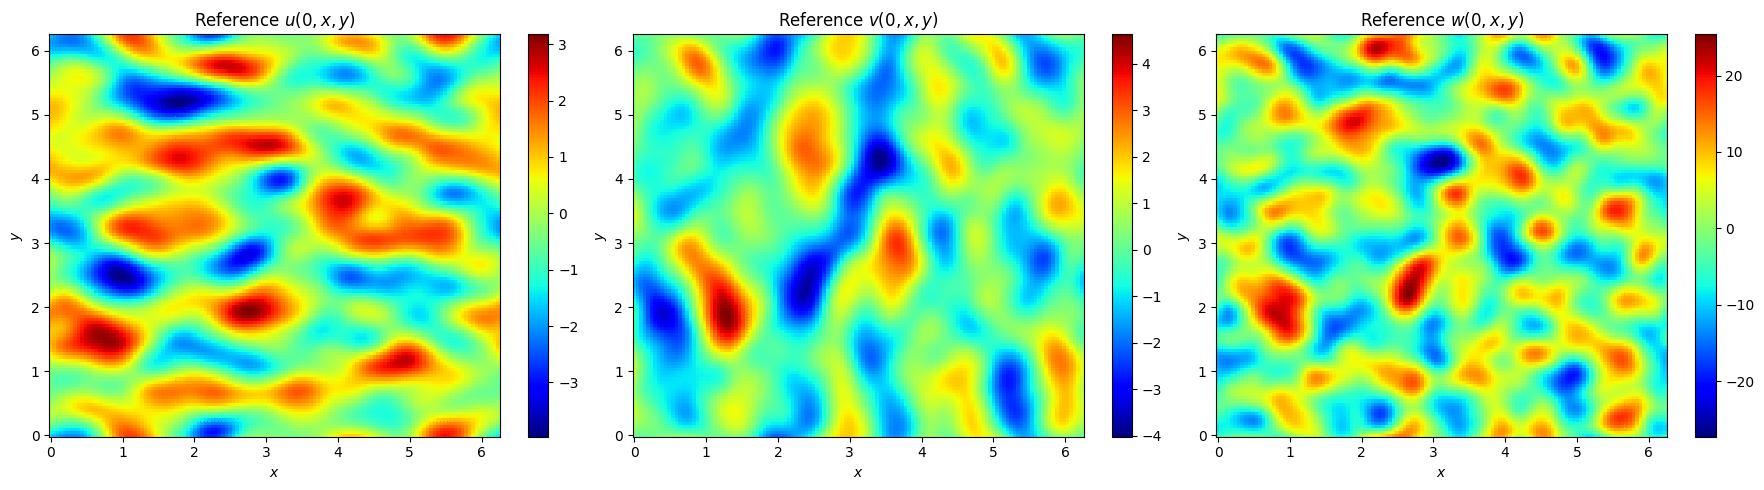

In [4]:
dtdt = 1
N_t = 100 * dtdt
N_x = 100
N_y = 100
key = jax.random.PRNGKey(2023)
key, skey = jax.random.split(key)
dummy_x = jax.random.uniform(skey, (N_x, 1))
dummy_y = jax.random.uniform(skey, (N_y, 1))
key, skey = jax.random.split(skey)
params_u = net_u.init(skey, dummy_x, dummy_y)
params_v = net_v.init(skey, dummy_x, dummy_y)

# Load the reference solution
data = np.load('NS.npy', allow_pickle=True).item()
sol = data['sol']
t_star = data['t']
x_star = data['x']
y_star = data['y']
u0 = data['u0']
v0 = data['v0']
w0 = data['w0']
nu = data['viscosity']
XX, YY = np.meshgrid(x_star, y_star)
XX = XX.T
YY = YY.T

# Plot the reference solution
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(XX, YY, u0, cmap='jet')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(r'Reference $u(0,x,y)$')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(XX, YY, v0, cmap='jet')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(r'Reference $v(0,x,y)$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(XX, YY, w0, cmap='jet')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(r'Reference $w(0,x,y)$')
plt.tight_layout()

# Sample point
X_r   = jnp.linspace(0, 2*jnp.pi, N_x)
Y_r   = jnp.linspace(0, 2*jnp.pi, N_y)
X_r, Y_r = jnp.meshgrid(X_r, Y_r)
X_r = X_r.T.reshape(-1, 1)                                  # used to train u
Y_r = Y_r.T.reshape(-1, 1)                                  # used to train u
X_star= XX.reshape(-1, 1)                                   # used to predict
Y_star= YY.reshape(-1, 1)                                   # used to predict
u0    = u0.reshape(-1, 1)                                   # reference solution of u(0,x,y)
v0    = v0.reshape(-1, 1)                                   # reference solution of v(0,x,y)
w0    = w0.reshape(-1, 1)                                   # reference solution of w(0,x,y)

In [5]:
# Train u0
start_time = time.time()
print('Training u0')

#logger
loss_u_log = []
loss_v_log = []
res_w_log = []
l2_u_log = []
l2_v_log = []
l2_w_log = []

# optimizer & schedule
lr = 1e-2
schedule = optax.exponential_decay(
    init_value=lr,
    transition_steps=100,
    decay_rate=0.95
)
optimizer = optax.adam(learning_rate=schedule)

# Train state
state_u = train_state.TrainState.create(apply_fn=net_u.apply, params=params_u, tx=optimizer)
state_v = train_state.TrainState.create(apply_fn=net_v.apply, params=params_v, tx=optimizer)

# Load state
# pkl_file = pickle.load(open('states/state{:d}.pkl'.format(0), 'rb'))
# state = flax.serialization.from_state_dict(state, pkl_file)

pbar = trange(1, 10000 + 1, ncols=180)
loss_min = 1e8
for nIter in pbar:
    state_u, state_v, loss_u, loss_v, loss_w, loss_c = train_step_u0(state_u, state_v, X_star, Y_star, u0, v0, w0)
    loss = loss_u + loss_v + loss_w + loss_c

    # Save the best state
    if loss < loss_min:
        state_dict_u = flax.serialization.to_state_dict(state_u)
        state_dict_v = flax.serialization.to_state_dict(state_v)
        pickle.dump(state_dict_u, open('states/state_u{:d}.pkl'.format(0), 'wb'))
        pickle.dump(state_dict_v, open('states/state_v{:d}.pkl'.format(0), 'wb'))
        loss_min = loss

    if nIter % 100 == 0:
        l2_u = jnp.linalg.norm(u0 - net(state_u, state_u.params, X_star, Y_star)) / jnp.linalg.norm(u0)
        l2_v = jnp.linalg.norm(v0 - net(state_v, state_v.params, X_star, Y_star)) / jnp.linalg.norm(v0)
        l2_w = jnp.linalg.norm(w0 - w_net(state_u, state_v, state_u.params, state_v.params, X_star, Y_star)) / jnp.linalg.norm(w0)

        loss_u_log.append(loss_u)
        loss_v_log.append(loss_v)
        res_w_log.append(loss_w)
        l2_u_log.append(l2_u)
        l2_v_log.append(l2_v)
        l2_w_log.append(l2_w)
        pbar.set_postfix_str('loss:{:.2e}, min:{:.2e}, u:{:.2e}, v:{:.2e}, w:{:.2e}, c:{:.2e}, l2_u:{:.2e}, l2_v:{:.2e}, l2_w:{:.2e}'
                             .format(loss, loss_min, loss_u, loss_v, loss_w, loss_c, l2_w, l2_v, l2_w))

elapsed_u0 = time.time() - start_time

Training u0


100%|███████████████| 10000/10000 [04:47<00:00, 34.82it/s, loss:6.31e-06, min:6.22e-06, u:1.35e-08, v:2.60e-08, w:3.33e-06, c:2.94e-06, l2_u:2.28e-04, l2_v:8.68e-05, l2_w:2.28e-04]


In [5]:
# Load the best state
schedule = optax.exponential_decay(init_value=1e-3, transition_steps=1000, decay_rate=0.9)
optimizer = optax.adam(learning_rate=schedule)
state_u = train_state.TrainState.create(apply_fn=net_u.apply, params=params_u, tx=optimizer)
state_v = train_state.TrainState.create(apply_fn=net_v.apply, params=params_v, tx=optimizer)
pkl_file_u = pickle.load(open('states/state_u{:d}.pkl'.format(0), 'rb'))
pkl_file_v = pickle.load(open('states/state_v{:d}.pkl'.format(0), 'rb'))
state_u = flax.serialization.from_state_dict(state_u, pkl_file_u)
state_v = flax.serialization.from_state_dict(state_v, pkl_file_v)

# Log u0
u_pred = []
v_pred = []
w_pred = []
l2_each_tn_log = []

u_pred.append(net(state_u, state_u.params, X_star, Y_star))
v_pred.append(net(state_v, state_v.params, X_star, Y_star))
w_pred.append(w_net(state_u, state_v, state_u.params, state_v.params, X_star, Y_star).reshape(len(x_star), len(y_star)))
sol_w = sol[0:1,:,:].reshape(len(w_pred[0]),-1)
l2_each_tn_log.append(jnp.linalg.norm(sol_w - w_pred[-1]) / jnp.linalg.norm(sol_w))

In [6]:
def pred_plot(true, pred, text):
    true = true.reshape(len(x_star), len(y_star))
    pred = pred.reshape(len(x_star), len(y_star))

    fig = plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.pcolor(XX, YY, true, cmap='jet')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(f'Reference {text}')
    plt.tight_layout()

    plt.subplot(1, 3, 2)
    plt.pcolor(XX, YY, pred, cmap='jet')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(f'Predicted {text}')
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    plt.pcolor(XX, YY, abs(true - pred), cmap='jet')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Absolute error')
    plt.tight_layout()
    plt.show()

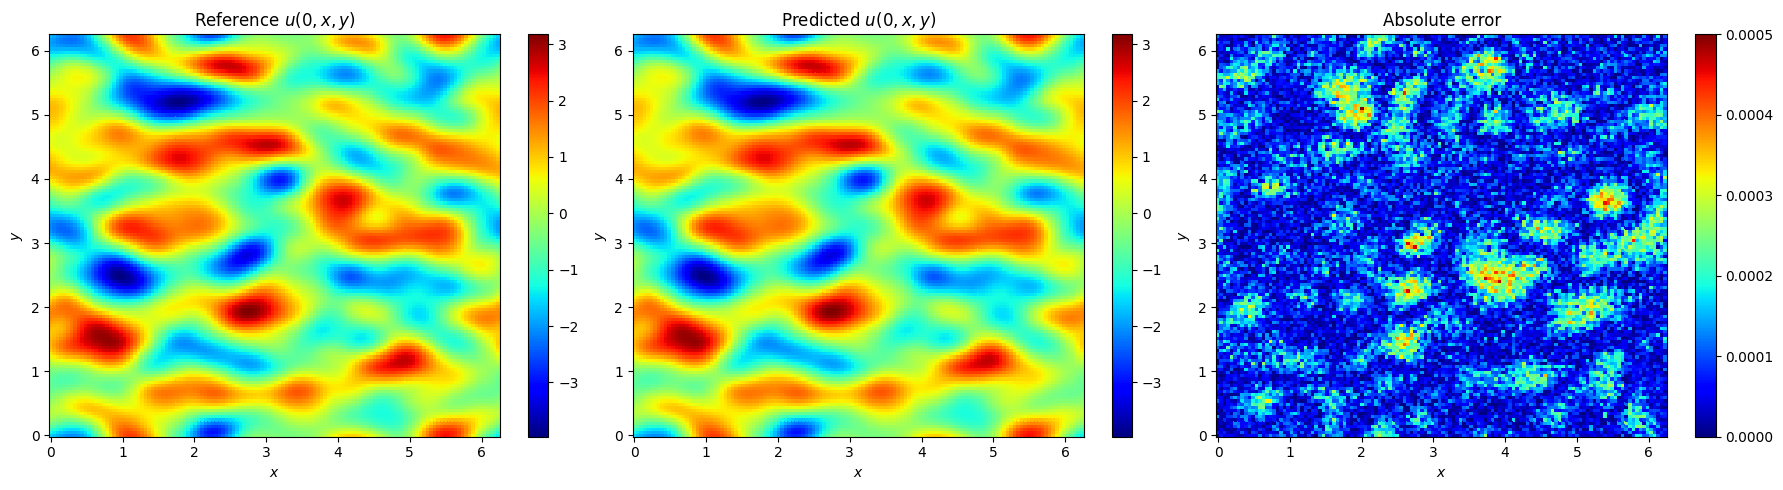

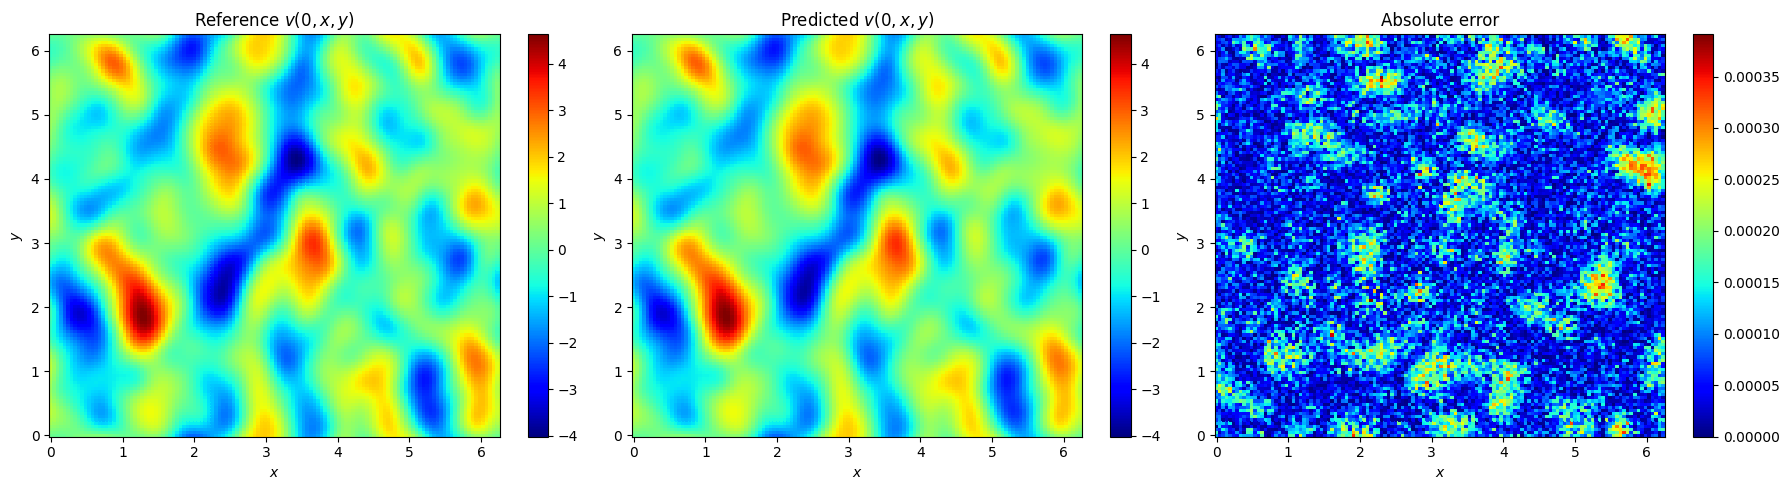

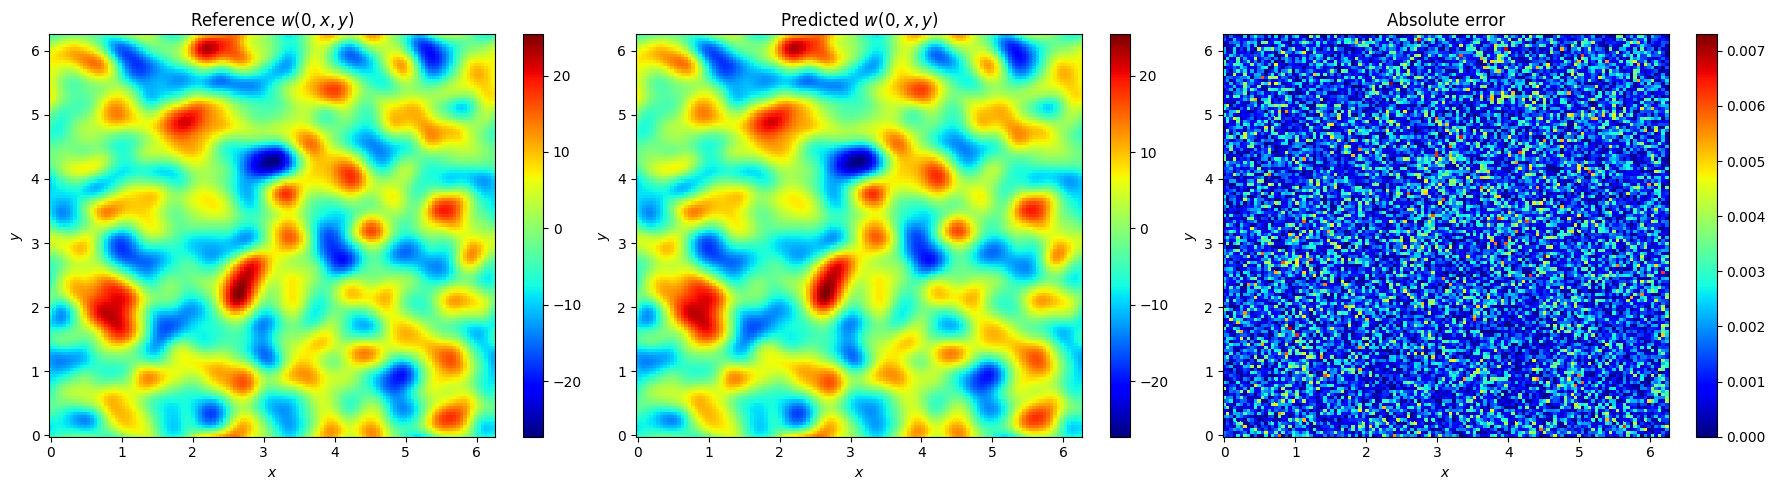

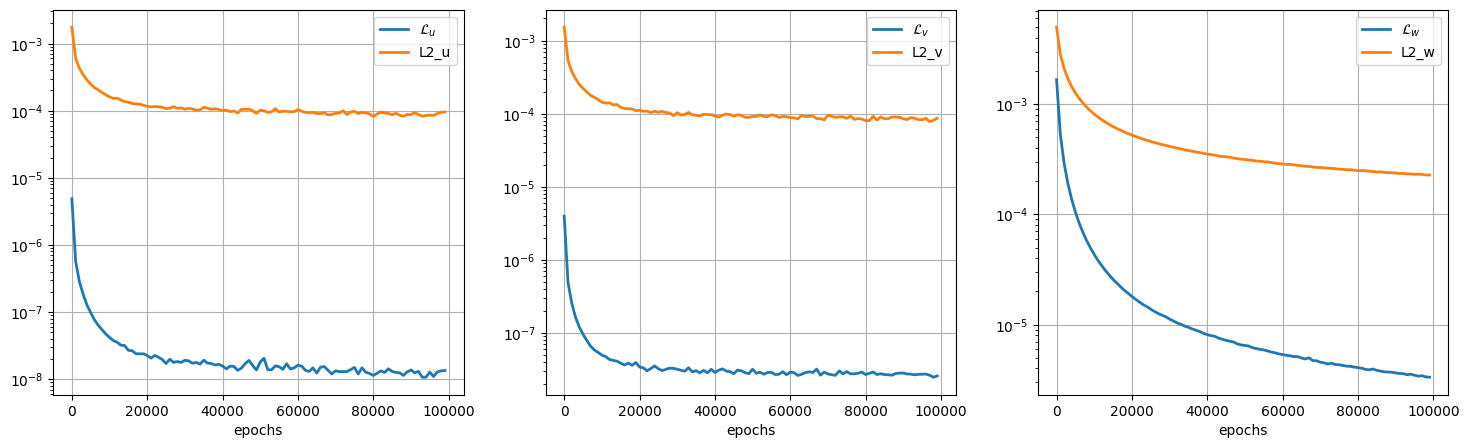

u0 training time: 287 s
L2 error: 2.29e-04


In [9]:
pred_plot(u0, u_pred[0], '$u(0,x,y)$')
pred_plot(v0, v_pred[0], '$v(0,x,y)$')
pred_plot(w0, w_pred[0], '$w(0,x,y)$')

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.yscale('log')
plt.plot(1000*np.arange(len(loss_u_log)), loss_u_log, label='$\mathcal{L}_{u}$', linewidth=2)
plt.plot(1000*np.arange(len(l2_u_log)), l2_u_log, label='L2_u', linewidth=2)
plt.xlabel('epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.yscale('log')
plt.plot(1000*np.arange(len(loss_v_log)), loss_v_log, label='$\mathcal{L}_{v}$', linewidth=2)
plt.plot(1000*np.arange(len(l2_v_log)), l2_v_log, label='L2_v', linewidth=2)
plt.xlabel('epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.yscale('log')
plt.plot(1000*np.arange(len(res_w_log)), res_w_log, label='$\mathcal{L}_{w}$', linewidth=2)
plt.plot(1000*np.arange(len(l2_w_log)), l2_w_log, label='L2_w', linewidth=2)
plt.xlabel('epochs')
plt.legend()
plt.grid(True)
plt.show()

print('u0 training time: {:.0f} s'.format(elapsed_u0))
print('L2 error: {:.2e}'.format(l2_each_tn_log[0]))

In [7]:
# Train u1 u2 u3 ...
start_time_rest = time.time()
print('Training u1 u2 u3 ...')

# logger
steps_each_tn_log = []
loss_min_log = []
res_w_log = []
res_c_log = []

# optimizer & schedule
lr = 1e-3
schedule = optax.exponential_decay(
    init_value=lr,
    transition_steps=100,
    decay_rate=0.9
)
optimizer = optax.adam(learning_rate=schedule)

pbar = trange(1, N_t + 1, ncols=150)
# pbar = trange(1,  10 + 1, ncols=150)
for t_n in pbar:

    loss_last = 0
    loss_min = 1e8
    loss_patience = 0
    res_w_each_tn_log = []
    res_c_each_tn_log = []
    
    uk_fn = lambda x, y: net(state_u, state_u.params, x, y)
    uk_x_fn = diff(uk_fn, 0)
    uk = uk_fn(X_r, Y_r)
    uk_x = uk_x_fn(X_r, Y_r)

    vk_fn = lambda x, y: net(state_v, state_v.params, x, y)
    vk_y_fn = diff(vk_fn, 1)
    vk = vk_fn(X_r, Y_r)
    vk_y = vk_y_fn(X_r, Y_r)

    wk_fn = lambda x, y: w_net(state_u, state_v, state_u.params, state_v.params, x, y)
    wk_x_fn = diff(wk_fn, 0)
    wk_xx_fn = diff(wk_x_fn, 0)
    wk_y_fn = diff(wk_fn, 1)
    wk_yy_fn = diff(wk_y_fn, 1)
    wk = wk_fn(X_r, Y_r)
    wk_x = wk_x_fn(X_r, Y_r)
    wk_xx = wk_xx_fn(X_r, Y_r)
    wk_y = wk_y_fn(X_r, Y_r)
    wk_yy = wk_yy_fn(X_r, Y_r)

    state_u = train_state.TrainState.create(apply_fn=net_u.apply, params=state_u.params, tx=optimizer)
    state_v = train_state.TrainState.create(apply_fn=net_v.apply, params=state_v.params, tx=optimizer)

    for steps in range(1, 10000 + 1):
        state_u, state_v, loss, loss_w, loss_c = train_step_rest(state_u, state_v, X_r, Y_r, wk, wk_x, wk_xx, wk_y, wk_yy, uk, uk_x, vk, vk_y, N_t, nu)
        pbar.set_postfix_str('steps:{:4d}, loss:{:.2e}, min:{:.2e}, w:{:.2e}, c:{:.2e}, l2_last:{:.2e}'
                             .format(steps, loss, loss_min, loss_w, loss_c, l2_each_tn_log[-1]))
        res_w_each_tn_log.append(loss_w)
        res_c_each_tn_log.append(loss_c)
        
        # Save the best state
        if loss < loss_min:
            state_dict_u = flax.serialization.to_state_dict(state_u)
            state_dict_v = flax.serialization.to_state_dict(state_v)
            pickle.dump(state_dict_u, open('states/state_u{:d}.pkl'.format(t_n), 'wb'))
            pickle.dump(state_dict_v, open('states/state_v{:d}.pkl'.format(t_n), 'wb'))
            loss_min = loss 
            loss_patience = steps
        
        # if steps>1000 and loss<2e-1 and (0<loss_last-loss<=1e-8 or steps-loss_patience>300):
        if steps>500 and (loss<5e-2 or 0<loss_last-loss<=1e-8 or steps-loss_patience>300):
            break
        loss_last = loss

    # Load the best state
    pkl_file_u = pickle.load(open('states/state_u{:d}.pkl'.format(t_n), 'rb'))
    pkl_file_v = pickle.load(open('states/state_v{:d}.pkl'.format(t_n), 'rb'))
    state_u = flax.serialization.from_state_dict(state_u, pkl_file_u)
    state_v = flax.serialization.from_state_dict(state_v, pkl_file_v)
    if t_n % dtdt == 0:
        w_pred.append(w_net(state_u, state_v, state_u.params, state_v.params, X_star, Y_star).reshape(len(x_star), len(y_star)))
        sol_index = int(t_n/dtdt)
        sol_w = sol[sol_index:sol_index+1,:,:].reshape(len(w_pred[0]),-1)
        l2_each_tn_log.append(jnp.linalg.norm(sol_w - w_pred[-1]) / jnp.linalg.norm(sol_w))
    
    # Log
    steps_each_tn_log.append(steps)
    loss_min_log.append(loss_min)
    res_w_log.append(res_w_each_tn_log)
    res_c_log.append(res_c_each_tn_log)
    
elapsed_rest = time.time() - start_time_rest

Training u1 u2 u3 ...


100%|█████████████████████████| 100/100 [3:27:44<00:00, 124.64s/it, steps: 501, loss:4.60e-02, min:4.59e-02, w:1.20e-02, c:3.40e-04, l2_last:1.30e-01]


In [8]:
path = 'result_dn'
pickle.dump(w_pred, open(f'{path}/w_pred.pkl', 'wb'))
pickle.dump(res_w_log, open(f'{path}/res_w.pkl', 'wb'))
pickle.dump(res_c_log, open(f'{path}/res_c.pkl', 'wb'))
pickle.dump(loss_min_log, open(f'{path}/loss_min.pkl', 'wb'))
pickle.dump(l2_each_tn_log, open(f'{path}/l2_each_tn.pkl', 'wb'))

In [9]:
# path = 'result_dn'
# w_pred = pickle.load(open(f'{path}/w_pred.pkl', 'rb'))
# res_w_log = pickle.load(open(f'{path}/res_w.pkl', 'rb'))
# res_c_log = pickle.load(open(f'{path}/res_c.pkl', 'rb'))
# loss_min_log = pickle.load(open(f'{path}/loss_min.pkl', 'rb'))
# l2_each_tn_log = pickle.load(open(f'{path}/l2_each_tn.pkl', 'rb'))

In [10]:
schedule = optax.exponential_decay(init_value=1e-3, transition_steps=1000, decay_rate=0.9)
optimizer = optax.adam(learning_rate=schedule)
state_u = train_state.TrainState.create(apply_fn=net_u.apply, params=params_u, tx=optimizer)
state_v = train_state.TrainState.create(apply_fn=net_v.apply, params=params_v, tx=optimizer)
l2_each_tn_log = []
w_pred = []
for t_n in range(0, N_t+1):
    if t_n % dtdt == 0:
        pkl_file_u = pickle.load(open('states/state_u{:d}.pkl'.format(t_n), 'rb'))
        pkl_file_v = pickle.load(open('states/state_v{:d}.pkl'.format(t_n), 'rb'))
        state_u = flax.serialization.from_state_dict(state_u, pkl_file_u)
        state_v = flax.serialization.from_state_dict(state_v, pkl_file_v)

        w_pred.append(w_net(state_u, state_v, state_u.params, state_v.params, X_star, Y_star).reshape(len(x_star), len(y_star)))
        sol_index = int(t_n/N_t*100)
        sol_w = sol[sol_index:sol_index+1,:,:].reshape(len(w_pred[0]),-1)
        l2_each_tn_log.append(jnp.linalg.norm(sol_w - w_pred[-1]) / jnp.linalg.norm(sol_w))
print(len(l2_each_tn_log))
print(len(w_pred))

101
101


In [11]:
w_pred_copy = w_pred

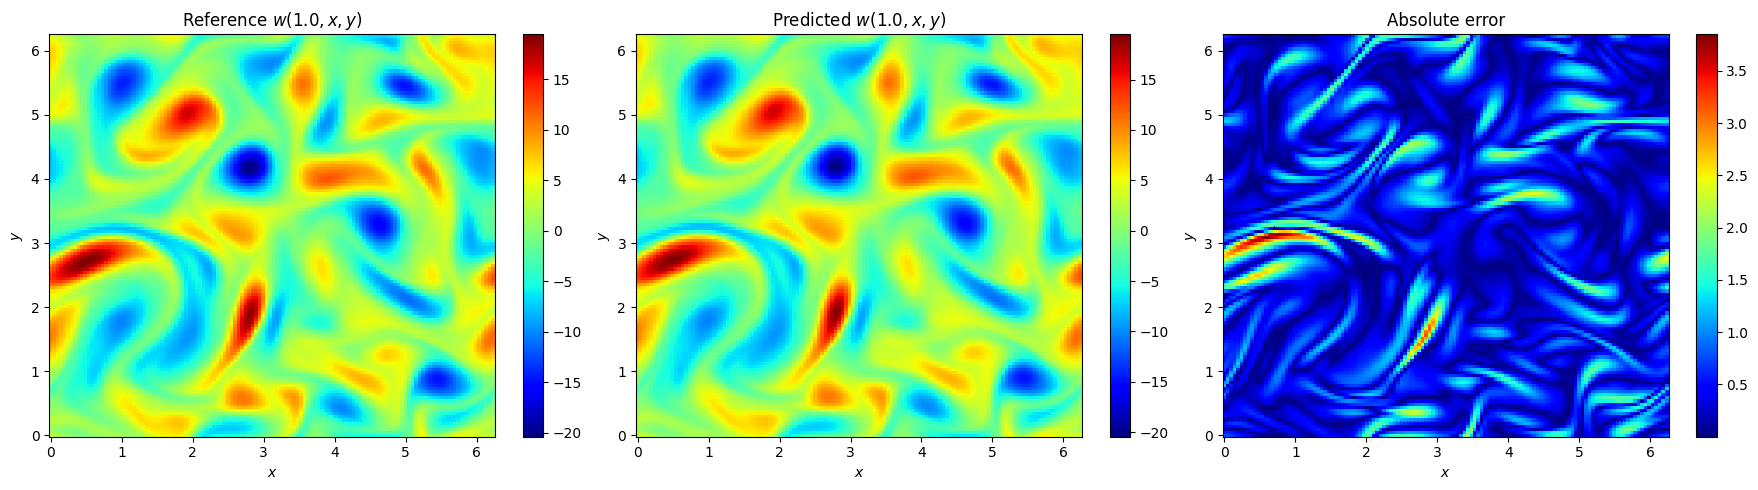

training time after u0: 12464 s
L2 error = 1.31305e-01


In [12]:
# compute L2 error
w_pred = w_pred_copy
sol_w = sol[100]
l2_w = np.linalg.norm(sol_w - w_pred[-1]) / np.linalg.norm(sol_w)

pred_plot(sol_w, w_pred[-1], '$w({:.1f},x,y)$'.format(1.0))

print('training time after u0: {:.0f} s'.format(elapsed_rest))
# print('total time: {:.0f} s'.format(elapsed_u0+elapsed_rest))
print('L2 error = {:.5e}'.format(l2_w))

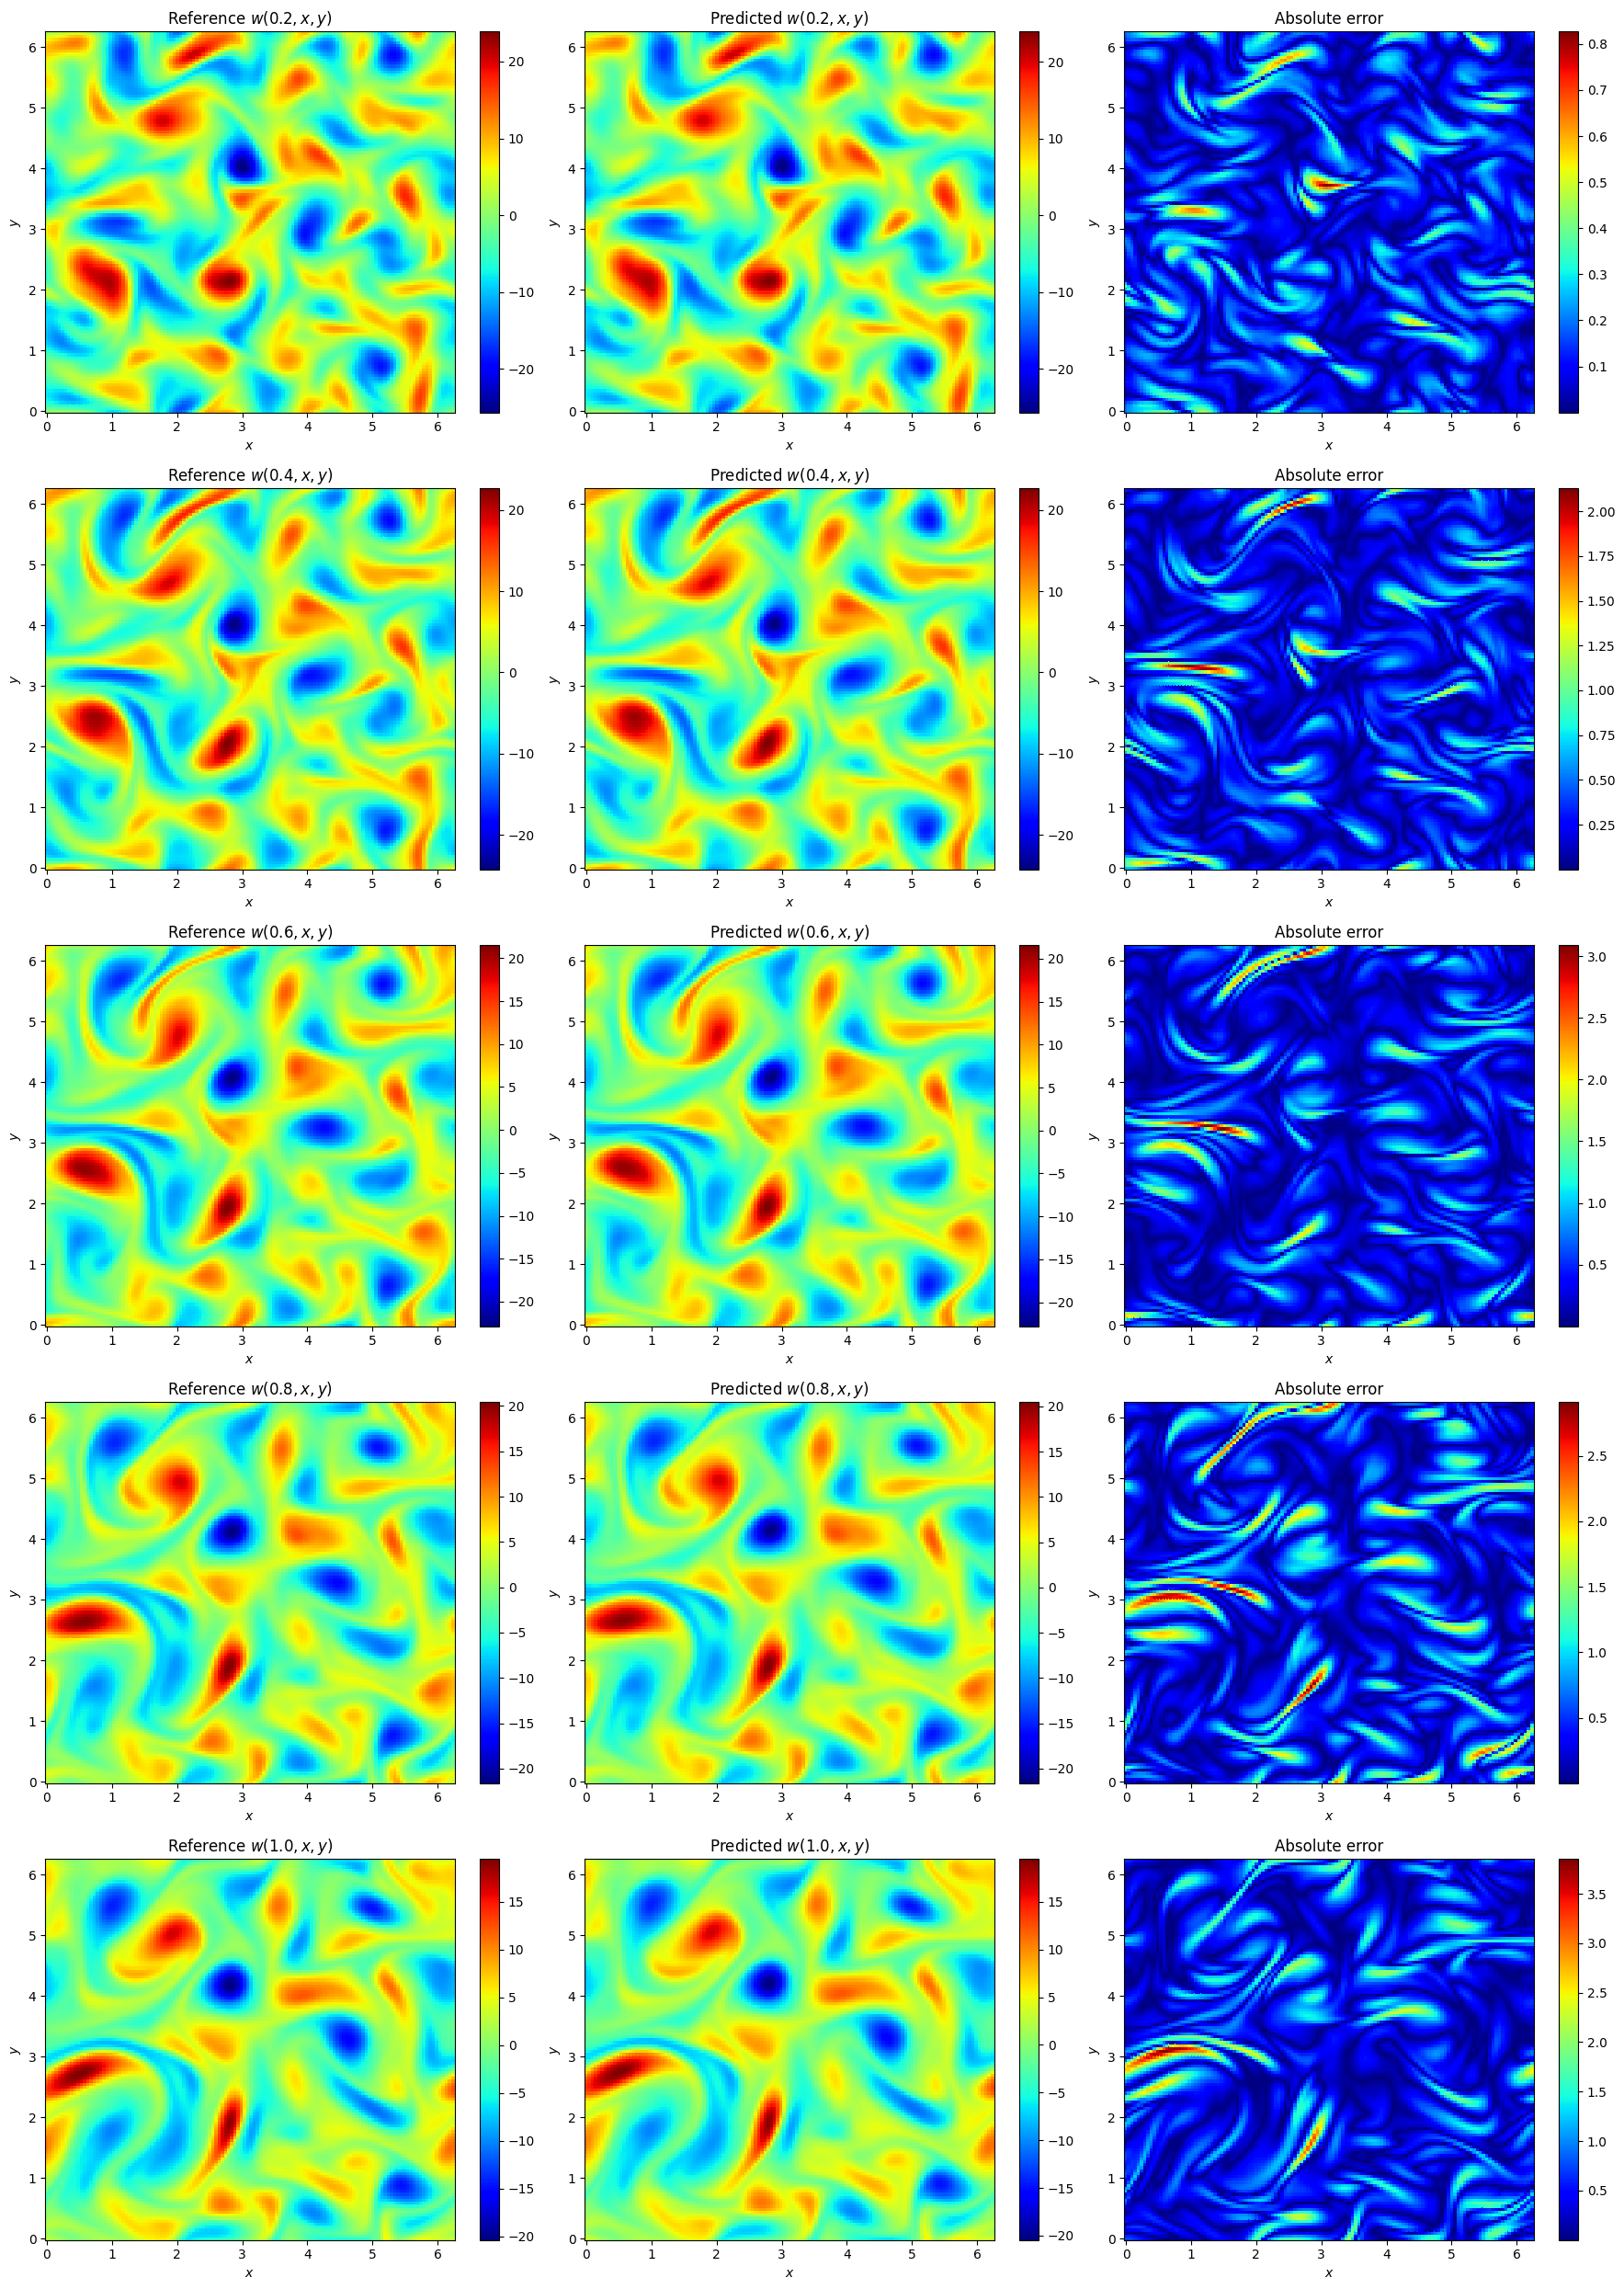

In [13]:
# plot t = 0.2, 0.4, 0.6, 0.8, 1.0
fig = plt.figure(figsize=(18, 25))
for t in range(1, 6):
    plt.subplot(5, 3, 3*t-2)
    plt.pcolor(XX, YY, sol[20*t], cmap='jet')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Reference $w({:.1f},x,y)$'.format(t*0.2))
    plt.tight_layout()

    plt.subplot(5, 3, 3*t-1)
    plt.pcolor(XX, YY, w_pred[20*t], cmap='jet')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Predicted $w({:.1f},x,y)$'.format(t*0.2))
    plt.tight_layout()

    plt.subplot(5, 3, 3*t)
    plt.pcolor(XX, YY, abs(sol[20*t] - w_pred[20*t]), cmap='jet')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Absolute error')
    plt.tight_layout()

plt.show()

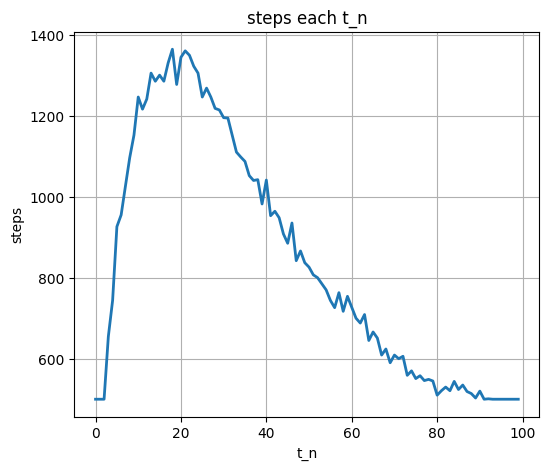

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(np.arange(len(steps_each_tn_log)), steps_each_tn_log, linewidth=2)
ax.set_xlabel('t_n')
ax.set_ylabel('steps')
ax.set_title('steps each t_n')
ax.grid(True)
plt.show()

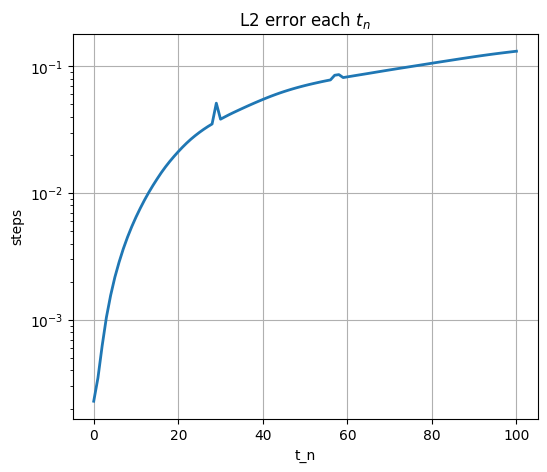

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.yscale('log')
ax.plot(np.arange(len(l2_each_tn_log)), l2_each_tn_log, linewidth=2)
ax.set_xlabel('t_n')
ax.set_ylabel('steps')
ax.set_title('L2 error each $t_n$')
ax.grid(True)
plt.show()

/tmp/ipykernel_3837081/3899144498.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


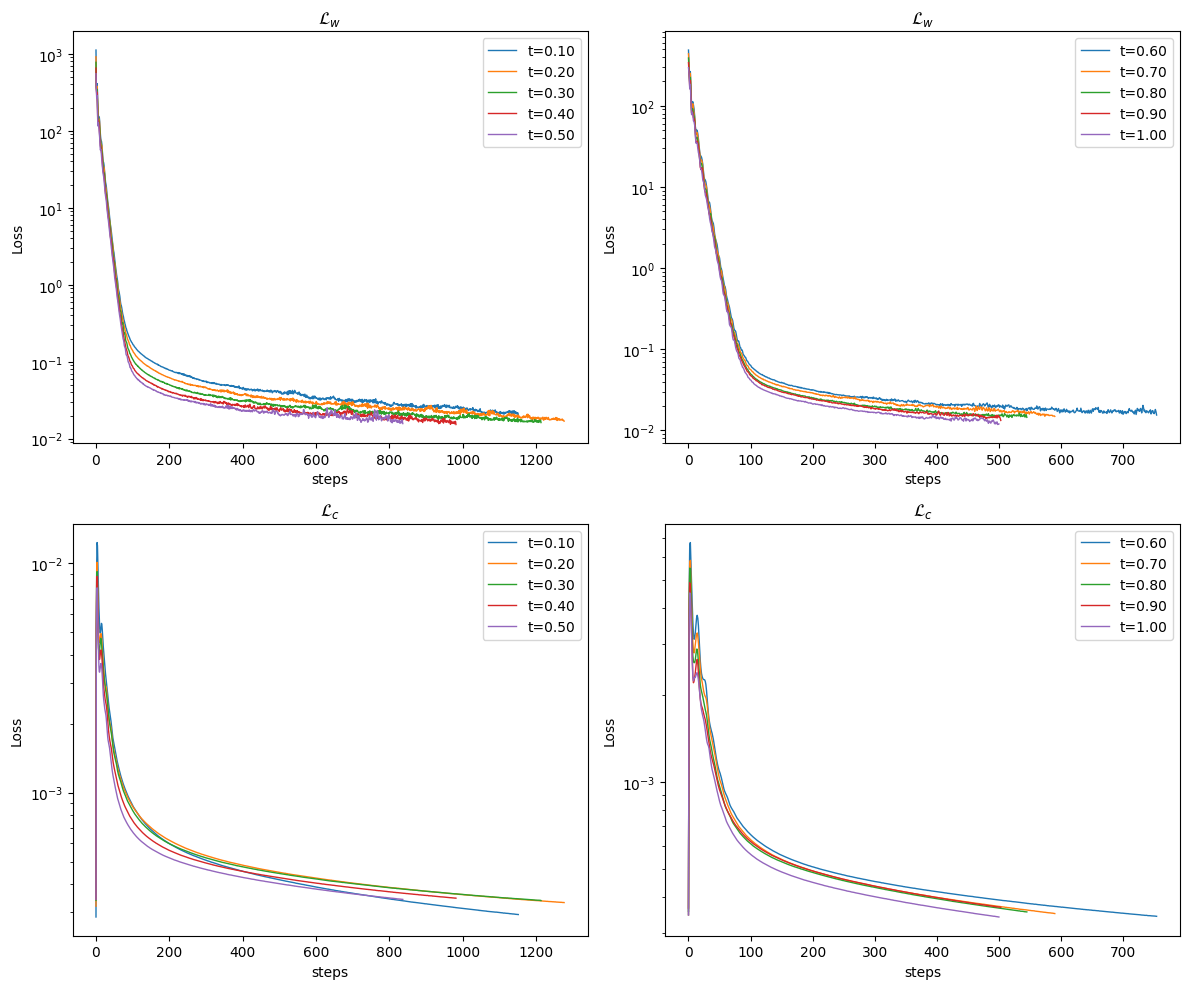

In [16]:
# res_w values of several time stamps
fig = plt.figure(figsize=(12, 10))
plt.title('$\mathcal{L}_{w}$')
plt.subplot(2, 2, 1)
plt.yscale('log')
plt.plot(np.arange(len(res_w_log[9])), res_w_log[9], label='t=0.10', linewidth=1)
plt.plot(np.arange(len(res_w_log[19])), res_w_log[19], label='t=0.20', linewidth=1)
plt.plot(np.arange(len(res_w_log[29])), res_w_log[29], label='t=0.30', linewidth=1)
plt.plot(np.arange(len(res_w_log[39])), res_w_log[39], label='t=0.40', linewidth=1)
plt.plot(np.arange(len(res_w_log[49])), res_w_log[49], label='t=0.50', linewidth=1)
plt.xlabel('steps')
plt.ylabel('Loss')
plt.title('$\mathcal{L}_{w}$')
plt.legend()
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.yscale('log')
plt.plot(np.arange(len(res_w_log[59])), res_w_log[59], label='t=0.60', linewidth=1)
plt.plot(np.arange(len(res_w_log[69])), res_w_log[69], label='t=0.70', linewidth=1)
plt.plot(np.arange(len(res_w_log[79])), res_w_log[79], label='t=0.80', linewidth=1)
plt.plot(np.arange(len(res_w_log[89])), res_w_log[89], label='t=0.90', linewidth=1)
plt.plot(np.arange(len(res_w_log[99])), res_w_log[99], label='t=1.00', linewidth=1)
plt.xlabel('steps')
plt.ylabel('Loss')
plt.title('$\mathcal{L}_{w}$')
plt.legend()
plt.tight_layout()

plt.subplot(2, 2, 3)
plt.yscale('log')
plt.plot(np.arange(len(res_c_log[9])), res_c_log[9], label='t=0.10', linewidth=1)
plt.plot(np.arange(len(res_c_log[19])), res_c_log[19], label='t=0.20', linewidth=1)
plt.plot(np.arange(len(res_c_log[29])), res_c_log[29], label='t=0.30', linewidth=1)
plt.plot(np.arange(len(res_c_log[39])), res_c_log[39], label='t=0.40', linewidth=1)
plt.plot(np.arange(len(res_c_log[49])), res_c_log[49], label='t=0.50', linewidth=1)
plt.xlabel('steps')
plt.ylabel('Loss')
plt.title('$\mathcal{L}_{c}$')
plt.legend()
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.yscale('log')
plt.plot(np.arange(len(res_c_log[59])), res_c_log[59], label='t=0.60', linewidth=1)
plt.plot(np.arange(len(res_c_log[69])), res_c_log[69], label='t=0.70', linewidth=1)
plt.plot(np.arange(len(res_c_log[79])), res_c_log[79], label='t=0.80', linewidth=1)
plt.plot(np.arange(len(res_c_log[89])), res_c_log[89], label='t=0.90', linewidth=1)
plt.plot(np.arange(len(res_c_log[99])), res_c_log[99], label='t=1.00', linewidth=1)
plt.xlabel('steps')
plt.ylabel('Loss')
plt.title('$\mathcal{L}_{c}$')
plt.legend()
plt.tight_layout()

plt.show()